In [14]:
import pandas as pd

# 1. Load the dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# 2. Check for Missing Values
print("--- MISSING VALUES ---")
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])

# 3. Check Data Types
print("\n--- DATA TYPES ---")
print(df_train.dtypes)

# 4. Check Unique Values for Categorical Columns
# (This helps us decide how to encode them in the next step)
categorical_cols = df_train.select_dtypes(include=['object']).columns
print("\n--- UNIQUE VALUES IN CATEGORICAL COLUMNS ---")
for col in categorical_cols:
    # We skip ID and very high cardinality columns for clarity
    if col != 'founder_id' and df_train[col].nunique() < 20:
        print(f"{col}: {df_train[col].unique()}")

--- MISSING VALUES ---
monthly_revenue_generated     1800
work_life_balance_rating     10144
venture_satisfaction          7164
num_dependents                4780
team_size_category            2992
years_since_founding          4184
dtype: int64

--- DATA TYPES ---
founder_id                      int64
founder_age                     int64
founder_gender                 object
years_with_startup              int64
founder_role                   object
monthly_revenue_generated     float64
work_life_balance_rating       object
venture_satisfaction           object
startup_performance_rating     object
funding_rounds_led              int64
working_overtime               object
distance_from_investor_hub      int64
education_background           object
personal_status                object
num_dependents                float64
startup_stage                  object
team_size_category             object
years_since_founding          float64
remote_operations              object
leadership_s

--- MISSING VALUE PERCENTAGES ---
work_life_balance_rating     17.016994
venture_satisfaction         12.017916
num_dependents                8.018654
years_since_founding          7.018839
team_size_category            5.019208
monthly_revenue_generated     3.019577
dtype: float64


C:\Users\Aksha\AppData\Local\Temp\ipykernel_18436\1511211042.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train[col].fillna("NaN"), ax=axes[i], palette='viridis')
C:\Users\Aksha\AppData\Local\Temp\ipykernel_18436\1511211042.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train[col].fillna("NaN"), ax=axes[i], palette='viridis')
C:\Users\Aksha\AppData\Local\Temp\ipykernel_18436\1511211042.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train[col].fillna("NaN"), ax=axes[i], palette='viridis')


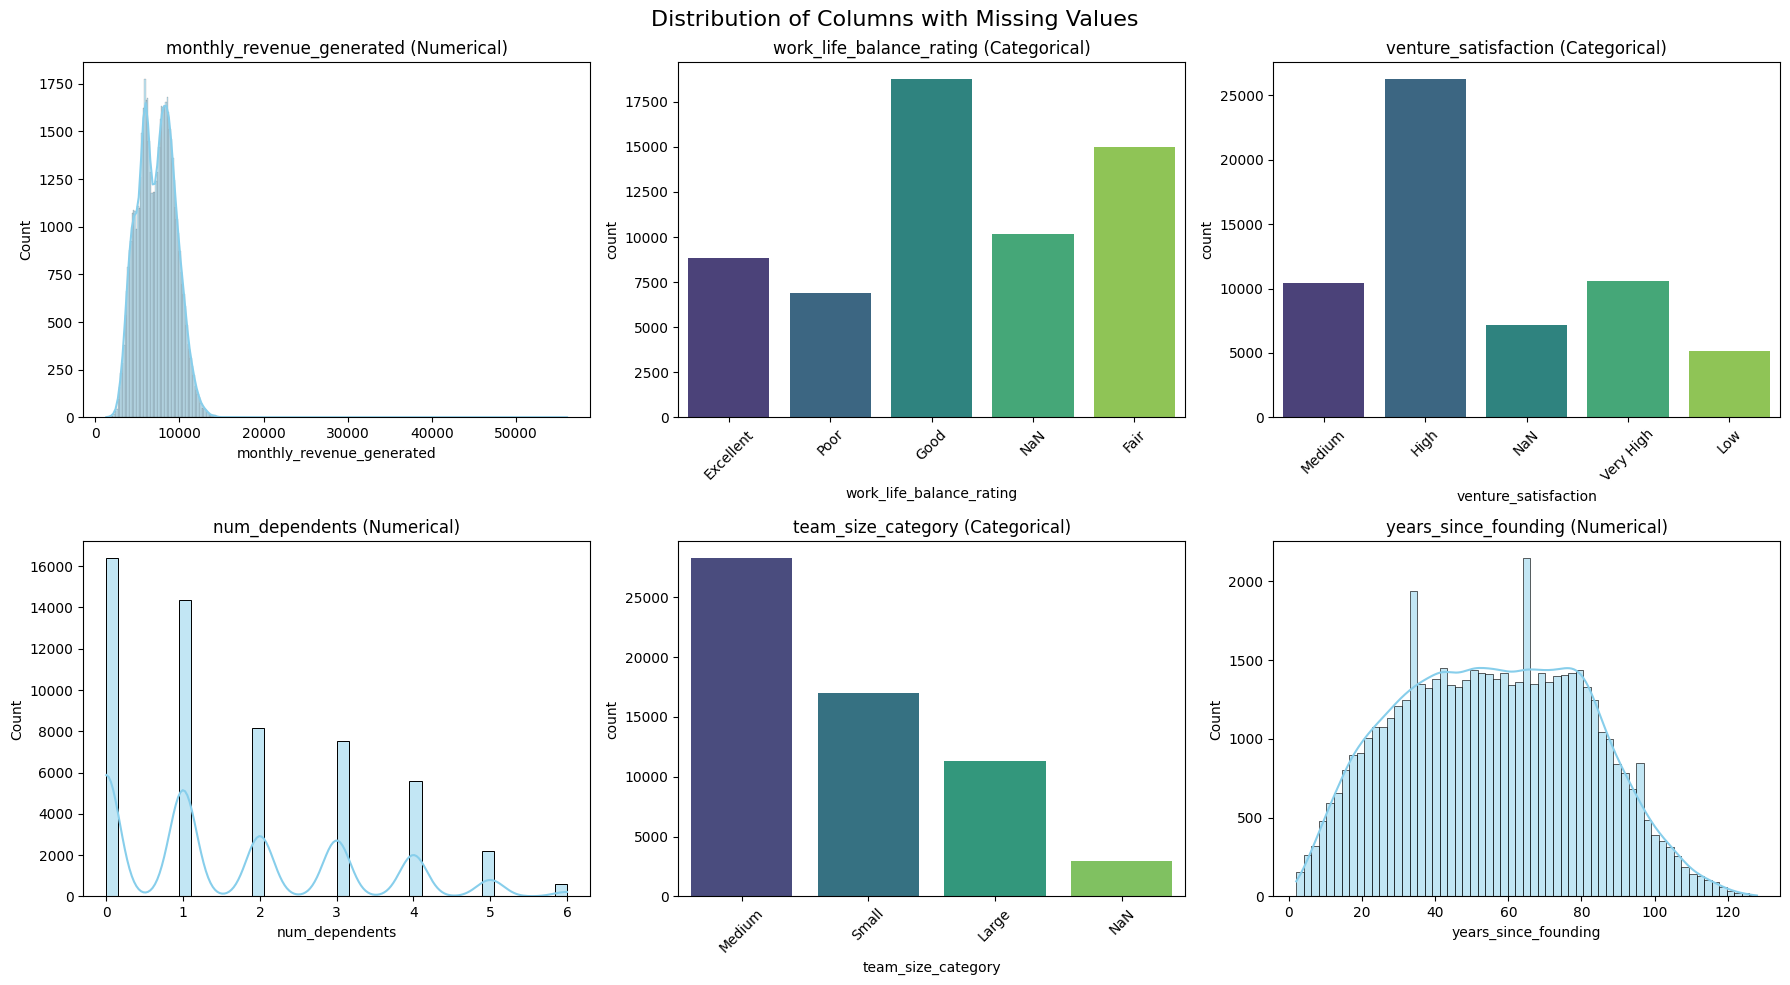


--- REVENUE SKEWNESS ---
Skewness: 0.7998130055124038


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate and Print Percentages
total_rows = len(df_train)
missing_data = df_train.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_percentage = (missing_data / total_rows) * 100

print("--- MISSING VALUE PERCENTAGES ---")
print(missing_percentage.sort_values(ascending=False))

# 2. Visualize Distributions to decide Imputation Strategy

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Columns with Missing Values', fontsize=16)
axes = axes.flatten()

# List of columns with missing values
missing_cols = missing_data.index.tolist()

for i, col in enumerate(missing_cols):
    # Check if column is Numerical or Categorical
    if df_train[col].dtype == 'float64' or df_train[col].dtype == 'int64':
        # Numerical: Use Histogram
        sns.histplot(df_train[col].dropna(), kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f'{col} (Numerical)')
    else:
        # Categorical: Use Bar Chart
        sns.countplot(x=df_train[col].fillna("NaN"), ax=axes[i], palette='viridis')
        axes[i].set_title(f'{col} (Categorical)')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. Specific check for Revenue Skewness
print("\n--- REVENUE SKEWNESS ---")
print(f"Skewness: {df_train['monthly_revenue_generated'].skew()}")

In [16]:
# 1. Select only the columns with missing values for a focused look
missing_numericals = ['monthly_revenue_generated', 'num_dependents', 'years_since_founding']
missing_categoricals = ['work_life_balance_rating', 'venture_satisfaction', 'team_size_category']

# 2. Numerical Description (Checking Mean vs 50% Median)
print("--- NUMERICAL STATS (Compare Mean vs 50%) ---")
print(df_train[missing_numericals].describe())

# 3. Categorical Description (Checking the Mode/Top value)
print("\n--- CATEGORICAL FREQUENCIES ---")
for col in missing_categoricals:
    print(f"\nColumn: {col}")
    print(df_train[col].value_counts(dropna=False).head(5)) # Show top 5 to see the Mode

--- NUMERICAL STATS (Compare Mean vs 50%) ---
       monthly_revenue_generated  num_dependents  years_since_founding
count               57811.000000    54831.000000          55427.000000
mean                 7311.070350        1.648465             55.772909
std                  2197.444033        1.555767             25.395430
min                  1316.000000        0.000000              2.000000
25%                  5661.000000        0.000000             36.000000
50%                  7358.000000        1.000000             56.000000
75%                  8882.000000        3.000000             76.000000
max                 56050.000000        6.000000            128.000000

--- CATEGORICAL FREQUENCIES ---

Column: work_life_balance_rating
work_life_balance_rating
Good         18755
Fair         14972
NaN          10144
Excellent     8851
Poor          6889
Name: count, dtype: int64

Column: venture_satisfaction
venture_satisfaction
High         26255
Very High    10609
Medium       

In [17]:
# 1. Define the columns groups again
num_impute_cols = ['monthly_revenue_generated', 'num_dependents', 'years_since_founding']
cat_impute_cols = ['work_life_balance_rating', 'venture_satisfaction', 'team_size_category']

# 2. Numerical: Calculate Median on TRAIN only (Standard procedure)
num_fill_values = {}
for col in num_impute_cols:
    num_fill_values[col] = df_train[col].median()

# 3. Apply Imputation
# A. Numerical -> Fill with Median
for col in num_impute_cols:
    df_train[col] = df_train[col].fillna(num_fill_values[col])
    df_test[col] = df_test[col].fillna(num_fill_values[col])

# B. Categorical -> Fill with "Unknown" (Your smart suggestion)
for col in cat_impute_cols:
    df_train[col] = df_train[col].fillna('Unknown')
    df_test[col] = df_test[col].fillna('Unknown')

# 4. Verify changes
print("--- New Unique Values after filling 'Unknown' ---")
for col in cat_impute_cols:
    print(f"{col}: {df_train[col].unique()}")

print("\n--- VERIFICATION: Any Nulls left? ---")
print("Total Nulls:", df_train.isnull().sum().sum())

--- New Unique Values after filling 'Unknown' ---
work_life_balance_rating: ['Excellent' 'Poor' 'Good' 'Unknown' 'Fair']
venture_satisfaction: ['Medium' 'High' 'Unknown' 'Very High' 'Low']
team_size_category: ['Medium' 'Small' 'Large' 'Unknown']

--- VERIFICATION: Any Nulls left? ---
Total Nulls: 0


In [18]:
# 1. Define Mappings
# We use 0 for Unknown, and 1+ for the actual ratings increasing in quality
mapping_dict = {
    # Work Life Balance
    'work_life_balance_rating': {
        'Unknown': 0, 'Poor': 1, 'Fair': 2, 'Good': 3, 'Excellent': 4
    },
    
    # Venture Satisfaction
    'venture_satisfaction': {
        'Unknown': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4
    },
    
    # Team Size (Small < Medium < Large)
    'team_size_category': {
        'Unknown': 0, 'Small': 1, 'Medium': 2, 'Large': 3
    },
    
    # Startup Performance (Assuming standard scale based on your earlier description)
    'startup_performance_rating': {
        'Poor': 1, 'Average': 2, 'Good': 3, 'Excellent': 4
    },
    
    # Startup Reputation
    'startup_reputation': {
        'Poor': 1, 'Fair': 2, 'Good': 3, 'Excellent': 4
    },
    
    # Founder Visibility
    'founder_visibility': {
        'Low': 1, 'Medium': 2, 'High': 3
    }
}

# 2. Apply Mappings
# We use a loop to apply this to both Train and Test
ordinal_cols = list(mapping_dict.keys())

print("--- Applying Ordinal Mappings ---")
for col in ordinal_cols:
    # We map the values. If a value is not in the dict (like a typo), fillna(0) handles it.
    df_train[col] = df_train[col].map(mapping_dict[col]).fillna(0).astype(int)
    df_test[col] = df_test[col].map(mapping_dict[col]).fillna(0).astype(int)
    print(f"Mapped {col}...")

# 3. Verify the Result
print("\n--- Verification: First 5 Rows of Mapped Columns ---")
print(df_train[ordinal_cols].head())

# 4. CHECK: We need to see Startup Stage to map it correctly next
print("\n--- CHECKING STARTUP STAGE ---")
print(df_train['startup_stage'].unique())

--- Applying Ordinal Mappings ---
Mapped work_life_balance_rating...
Mapped venture_satisfaction...
Mapped team_size_category...
Mapped startup_performance_rating...
Mapped startup_reputation...
Mapped founder_visibility...

--- Verification: First 5 Rows of Mapped Columns ---
   work_life_balance_rating  venture_satisfaction  team_size_category  \
0                         4                     2                   2   
1                         1                     3                   2   
2                         3                     3                   2   
3                         3                     3                   1   
4                         0                     0                   2   

   startup_performance_rating  startup_reputation  founder_visibility  
0                           2                   4                   2  
1                           0                   2                   1  
2                           0                   1                  

In [19]:
# 1. Identify remaining text columns (excluding the ones we already mapped)
# We check columns that are still of type 'object'
remaining_cats = df_train.select_dtypes(include=['object']).columns.tolist()

print("--- UNIQUE VALUES FOR REMAINING COLUMNS ---")
for col in remaining_cats:
    print(f"\nColumn: {col}")
    print(df_train[col].unique())

--- UNIQUE VALUES FOR REMAINING COLUMNS ---

Column: founder_gender
['Male' 'Female']

Column: founder_role
['Education' 'Media' 'Healthcare' 'Technology' 'Finance']

Column: working_overtime
['No' 'Yes']

Column: education_background
['Associate Degree' 'Master’s Degree' 'Bachelor’s Degree' 'High School'
 'PhD']

Column: personal_status
['Married' 'Divorced' 'Single']

Column: startup_stage
['Mid' 'Senior' 'Entry']

Column: remote_operations
['No' 'Yes']

Column: leadership_scope
['No' 'Yes']

Column: innovation_support
['No' 'Yes']

Column: retention_status
['Stayed' 'Left']


In [20]:
# 1. Ordinal Mappings (Education & Stage)
# mapping 'Unknown' to 0 to handle any missingness we filled earlier
edu_map = {'Unknown': 0, 'High School': 1, 'Associate Degree': 2, 'Bachelor’s Degree': 3, 'Master’s Degree': 4, 'PhD': 5}
stage_map = {'Unknown': 0, 'Entry': 1, 'Mid': 2, 'Senior': 3}

df_train['education_background'] = df_train['education_background'].map(edu_map).fillna(0).astype(int)
df_test['education_background'] = df_test['education_background'].map(edu_map).fillna(0).astype(int)

df_train['startup_stage'] = df_train['startup_stage'].map(stage_map).fillna(0).astype(int)
df_test['startup_stage'] = df_test['startup_stage'].map(stage_map).fillna(0).astype(int)

# 2. Binary Mappings (Yes -> 1, No -> 0)
binary_cols = ['working_overtime', 'remote_operations', 'leadership_scope', 'innovation_support']

for col in binary_cols:
    # Map Yes/No. If any value is not Yes/No, it becomes NaN, then fill with 0
    df_train[col] = df_train[col].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)
    df_test[col] = df_test[col].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

# 3. Target Encoding (Left -> 1, Stayed -> 0)
# We only do this for Train, as Test doesn't have the target
df_train['retention_status'] = df_train['retention_status'].map({'Left': 1, 'Stayed': 0}).astype(int)

# 4. One-Hot Encoding (Gender, Role, Personal Status)
# We use pd.get_dummies to turn "Role: Finance" into a column "founder_role_Finance"
nominal_cols = ['founder_gender', 'founder_role', 'personal_status']

df_train = pd.get_dummies(df_train, columns=nominal_cols, drop_first=True) # drop_first=True prevents multicollinearity
df_test = pd.get_dummies(df_test, columns=nominal_cols, drop_first=True)

# 5. Align Columns (Crucial for Kaggle)
# Ensure Test has same columns as Train (except target)
train_cols = [c for c in df_train.columns if c != 'retention_status']
for col in train_cols:
    if col not in df_test.columns:
        df_test[col] = 0 # Add missing column filled with 0s

# Ensure Test order matches Train
df_test = df_test[train_cols]

print("--- ENCODING COMPLETE ---")
print(f"Final Train Shape: {df_train.shape}")
print(f"Final Test Shape: {df_test.shape}")
print("\nFirst 3 rows of processed data:")
print(df_train.head(3))

--- ENCODING COMPLETE ---
Final Train Shape: (59611, 28)
Final Test Shape: (14900, 27)

First 3 rows of processed data:
   founder_id  founder_age  years_with_startup  monthly_revenue_generated  \
0        8410           31                  19                     5390.0   
1       64756           59                   4                     5534.0   
2       30257           24                  10                     8159.0   

   work_life_balance_rating  venture_satisfaction  startup_performance_rating  \
0                         4                     2                           2   
1                         1                     3                           0   
2                         3                     3                           0   

   funding_rounds_led  working_overtime  distance_from_investor_hub  ...  \
0                   2                 0                          22  ...   
1                   3                 0                          21  ...   
2                 

--- TOP PREDICTORS (Correlation with Retention) ---
retention_status              1.000000
personal_status_Single        0.282994
distance_from_investor_hub    0.095042
working_overtime              0.055653
venture_satisfaction          0.004362
founder_role_Media           -0.000921
founder_visibility           -0.001400
founder_role_Healthcare      -0.002554
founder_role_Technology      -0.003122
founder_role_Finance         -0.005999
Name: retention_status, dtype: float64

--- BOTTOM PREDICTORS (Inverse Correlation) ---
founder_age                -0.048846
years_with_startup         -0.064968
num_dependents             -0.074439
funding_rounds_led         -0.080501
founder_gender_Male        -0.101790
startup_reputation         -0.104918
work_life_balance_rating   -0.110068
remote_operations          -0.220480
personal_status_Married    -0.229165
startup_stage              -0.313604
Name: retention_status, dtype: float64


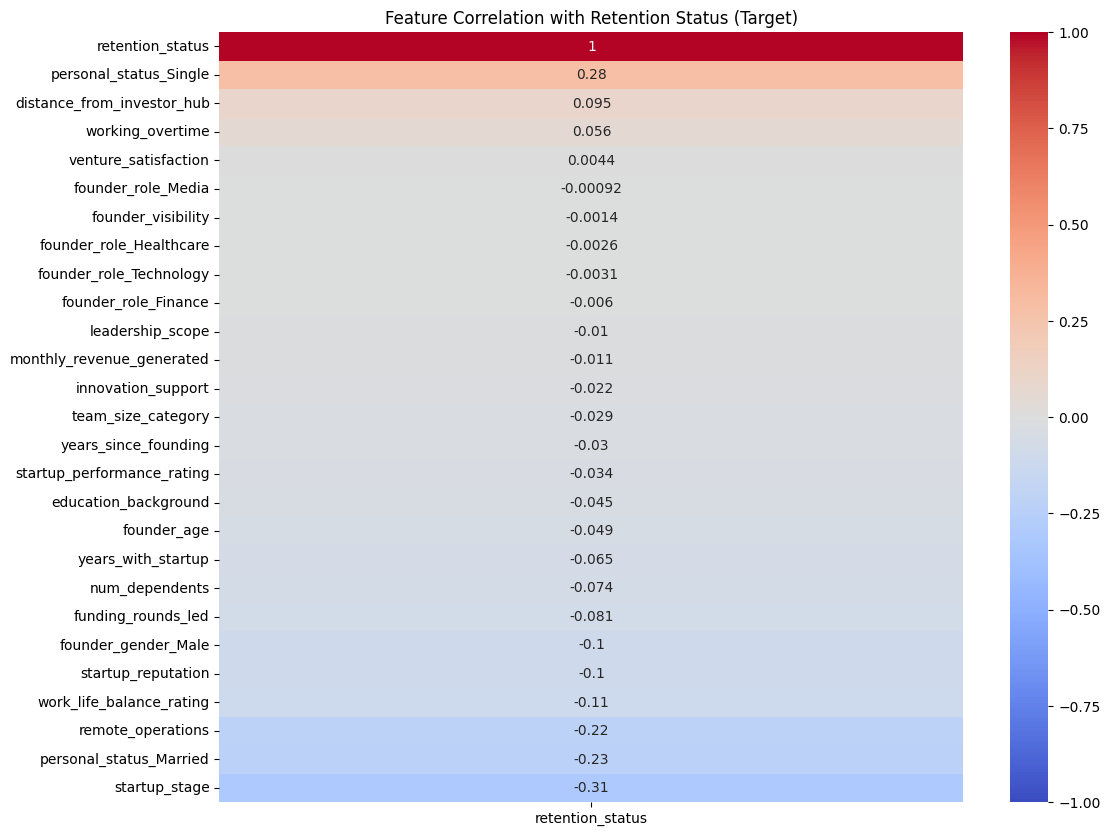

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Drop 'founder_id' (It's useless for prediction)
# We store the IDs for the submission file later, but remove from training data
train_ids = df_train['founder_id'] # Already have test_ids from before
df_train = df_train.drop('founder_id', axis=1)
df_test = df_test.drop('founder_id', axis=1)

# 2. Convert any Booleans to Integers (True/False -> 1/0)
df_train = df_train.astype(float)
df_test = df_test.astype(float)

# 3. THE SANITY CHECK: Correlation with Target
# We calculate how much each feature correlates with 'retention_status'
corr_matrix = df_train.corr()
target_corr = corr_matrix['retention_status'].sort_values(ascending=False)

print("--- TOP PREDICTORS (Correlation with Retention) ---")
print(target_corr.head(10)) # Top positive correlates (Predict 'Left')
print("\n--- BOTTOM PREDICTORS (Inverse Correlation) ---")
print(target_corr.tail(10)) # Top negative correlates (Predict 'Stayed')

# 4. Visualize the Matrix
plt.figure(figsize=(12, 10))
# Plotting a heatmap of correlations
sns.heatmap(corr_matrix[['retention_status']].sort_values(by='retention_status', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation with Retention Status (Target)")
plt.show()

In [22]:
import numpy as np

# 1. Create New Interaction Features
print("--- Creating New Features ---")

# A. Revenue Efficiency: How much money are they making per year of existence?
# (Adding +1 to avoid division by zero)
df_train['revenue_per_year_startup'] = df_train['monthly_revenue_generated'] / (df_train['years_since_founding'] + 1)
df_test['revenue_per_year_startup'] = df_test['monthly_revenue_generated'] / (df_test['years_since_founding'] + 1)

# B. Founder Experience Ratio: How much of the startup's life has this founder been there?
df_train['founder_tenure_ratio'] = df_train['years_with_startup'] / (df_train['years_since_founding'] + 1)
df_test['founder_tenure_ratio'] = df_test['years_with_startup'] / (df_test['years_since_founding'] + 1)

# C. Funding Efficiency: Revenue per Funding Round (Are they burning cash or making it?)
# (Adding +1 to avoid division by zero)
df_train['revenue_per_round'] = df_train['monthly_revenue_generated'] / (df_train['funding_rounds_led'] + 1)
df_test['revenue_per_round'] = df_test['monthly_revenue_generated'] / (df_test['funding_rounds_led'] + 1)

# D. Founder Burden: Age divided by Dependents (Proxy for "Stress" or "Stage of Life")
df_train['age_per_dependent'] = df_train['founder_age'] / (df_train['num_dependents'] + 1)
df_test['age_per_dependent'] = df_test['founder_age'] / (df_test['num_dependents'] + 1)

# E. Location Impact: Is high revenue correlated with being close to a hub?
df_train['revenue_distance_interaction'] = df_train['monthly_revenue_generated'] * df_train['distance_from_investor_hub']
df_test['revenue_distance_interaction'] = df_test['monthly_revenue_generated'] * df_test['distance_from_investor_hub']

print("Created 5 new interaction features.")

# 2. Check the correlation of these NEW features with the target
new_cols = ['revenue_per_year_startup', 'founder_tenure_ratio', 'revenue_per_round', 'age_per_dependent', 'revenue_distance_interaction', 'retention_status']
print("\n--- Correlation of NEW Features with Target ---")
print(df_train[new_cols].corr()['retention_status'].sort_values(ascending=False))

--- Creating New Features ---
Created 5 new interaction features.

--- Correlation of NEW Features with Target ---
retention_status                1.000000
revenue_distance_interaction    0.076833
revenue_per_round               0.036128
revenue_per_year_startup        0.022066
age_per_dependent               0.017150
founder_tenure_ratio           -0.045969
Name: retention_status, dtype: float64


In [23]:
# Define columns with heavy outliers (usually financial or distance metrics)
outlier_cols = ['monthly_revenue_generated', 'distance_from_investor_hub', 'revenue_per_year_startup']

print("\n--- Capping Outliers (Top 1%) ---")
for col in outlier_cols:
    # Calculate the 99th percentile cap value
    upper_limit = df_train[col].quantile(0.99)
    
    # Cap the values in Train and Test
    # Any value higher than upper_limit becomes upper_limit
    df_train[col] = np.where(df_train[col] > upper_limit, upper_limit, df_train[col])
    df_test[col] = np.where(df_test[col] > upper_limit, upper_limit, df_test[col])
    
    print(f"Capped {col} at {upper_limit:.2f}")


--- Capping Outliers (Top 1%) ---
Capped monthly_revenue_generated at 12136.90
Capped distance_from_investor_hub at 98.00
Capped revenue_per_year_startup at 894.52


In [24]:
# Skewed columns (Revenue usually needs this)
skew_cols = ['monthly_revenue_generated', 'revenue_per_year_startup', 'revenue_distance_interaction']

print("\n--- Applying Log Transformation ---")
for col in skew_cols:
    # We use np.log1p which is log(x + 1) to handle zeros safely
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])
    print(f"Log-transformed {col}")

print("\n--- Preprocessing Upgrade Complete ---")


--- Applying Log Transformation ---
Log-transformed monthly_revenue_generated
Log-transformed revenue_per_year_startup
Log-transformed revenue_distance_interaction

--- Preprocessing Upgrade Complete ---


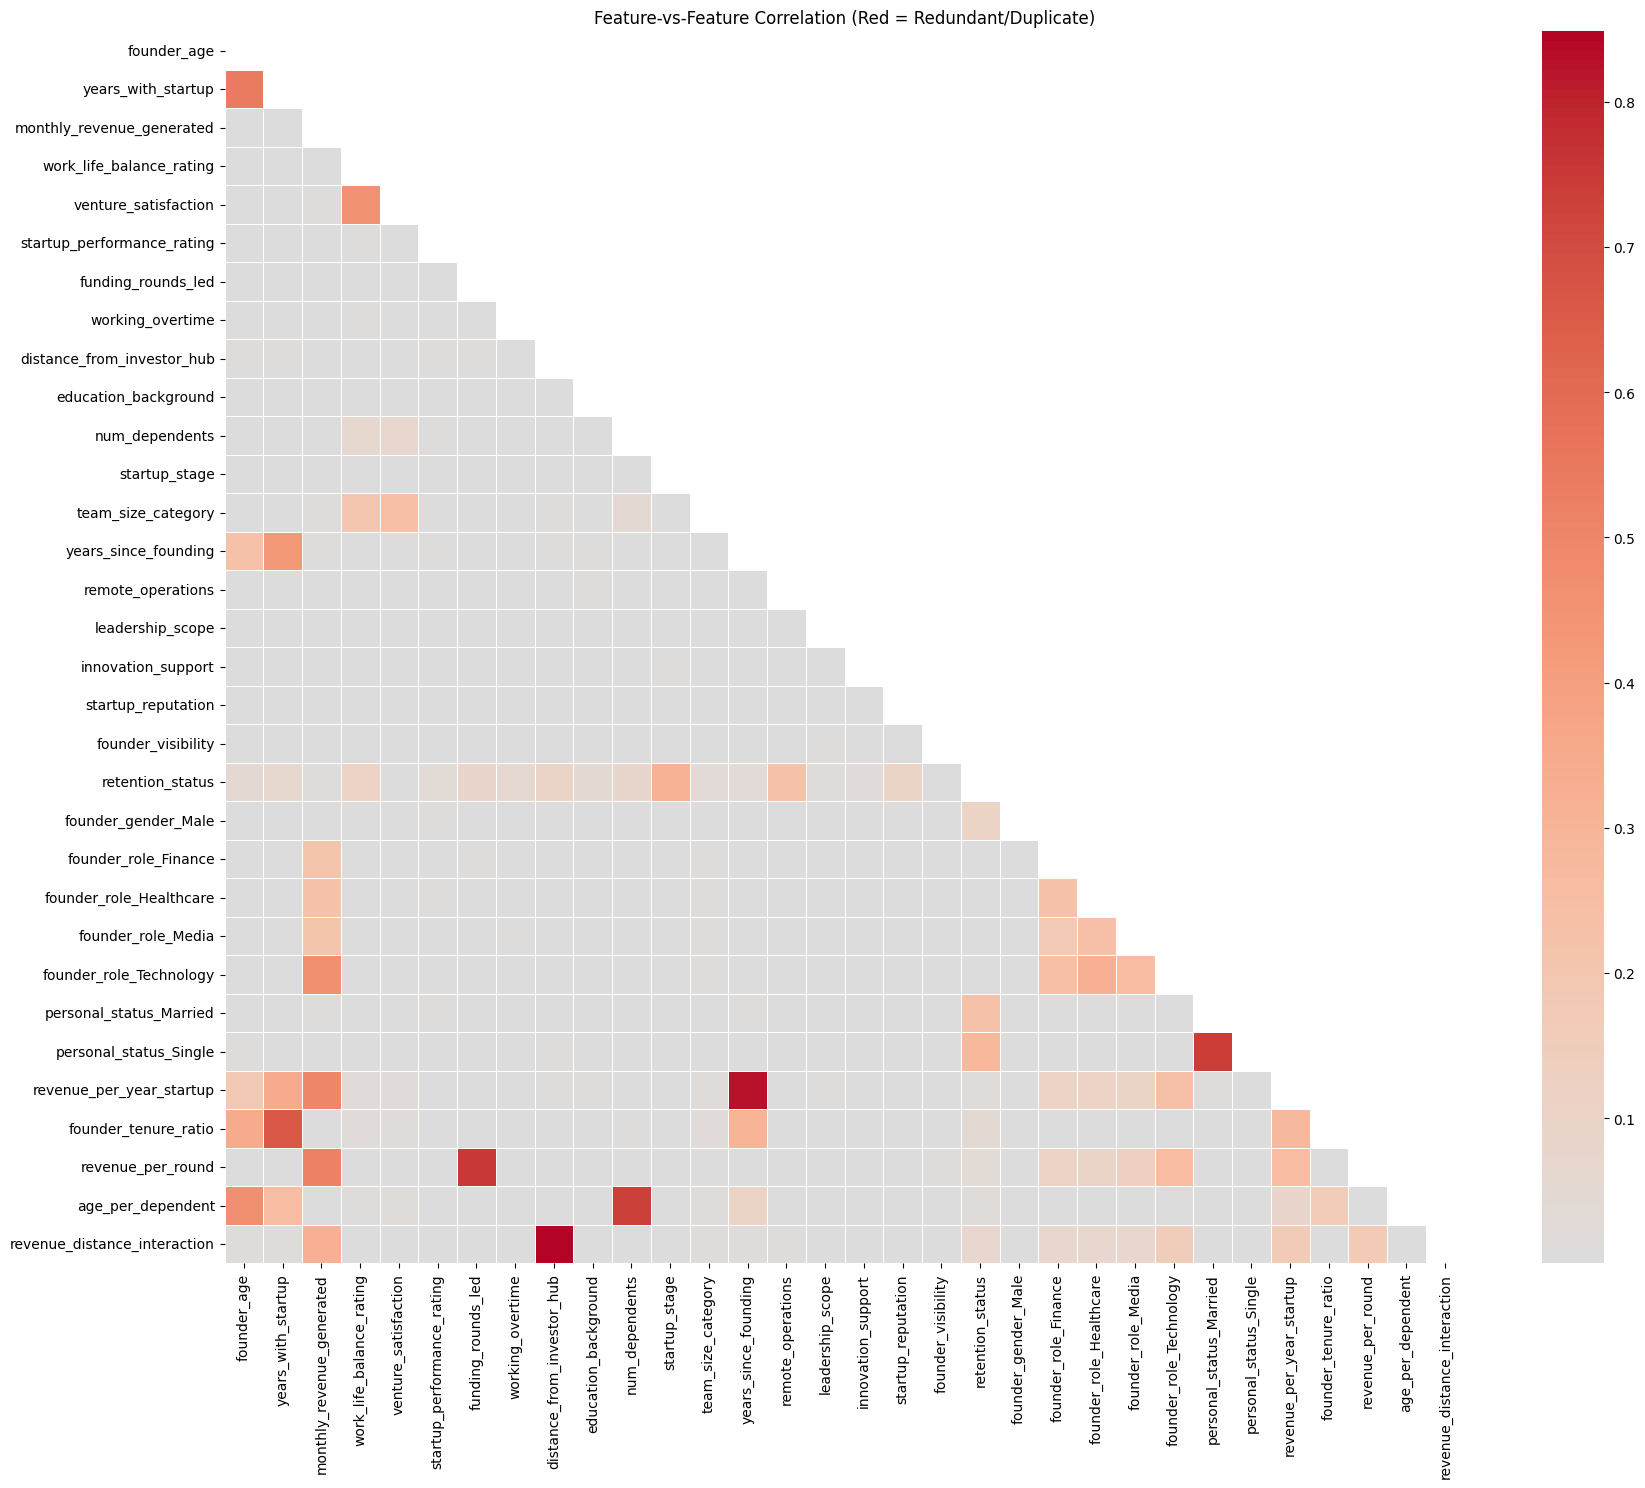

--- HIGHLY CORRELATED PAIRS (Potential Redundancy) ---
Series([], dtype: float64)


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate Correlation Matrix of ALL features
# We filter for absolute correlation > 0.8 to spot the "danger zones"
corr_matrix = df_train.corr().abs()

# 2. Create a mask to ignore the diagonal (correlation of 1 with itself)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 3. Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, mask=mask, center=0, cmap='coolwarm', linewidths=0.5)
plt.title("Feature-vs-Feature Correlation (Red = Redundant/Duplicate)")
plt.show()

# 4. Print pairs of features with correlation > 0.85
print("--- HIGHLY CORRELATED PAIRS (Potential Redundancy) ---")
# Unstack the matrix to get pairs
corr_pairs = corr_matrix.unstack()
# Filter for high correlation (excluding self-correlation)
high_corr = corr_pairs[(corr_pairs > 0.85) & (corr_pairs < 1.0)]
# Drop duplicates (A-B is same as B-A)
print(high_corr.drop_duplicates().sort_values(ascending=False))

In [26]:
# 1. Drop the Redundant Features identified in the Heatmap
cols_to_drop = ['revenue_distance_interaction', 'revenue_per_year_startup']

print(f"Dropping redundant columns: {cols_to_drop}")
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

# 2. Re-split the data (Since we dropped columns)
from sklearn.model_selection import train_test_split

X = df_train.drop('retention_status', axis=1)
y = df_train['retention_status']

# Stratify ensures we keep the same 51/49 balance in validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Final Scaling (StandardScaler)
# XGBoost doesn't strictly need this, but Logistic Regression & Neural Networks DO.
# It's good practice to have a scaled version ready.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(df_test) # Scale the actual test set too

print(f"--- FINAL DATA PREP COMPLETE ---")
print(f"Training Features: {X_train.shape[1]}")
print(f"Training Rows: {X_train.shape[0]}")

Dropping redundant columns: ['revenue_distance_interaction', 'revenue_per_year_startup']
--- FINAL DATA PREP COMPLETE ---
Training Features: 29
Training Rows: 47688
